In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
zip_path = '/content/drive/MyDrive/Braintumor classification/archive.zip'

extract_path = '/content/drive/MyDrive/Braintumor classification'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
!pip install Augmentor
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


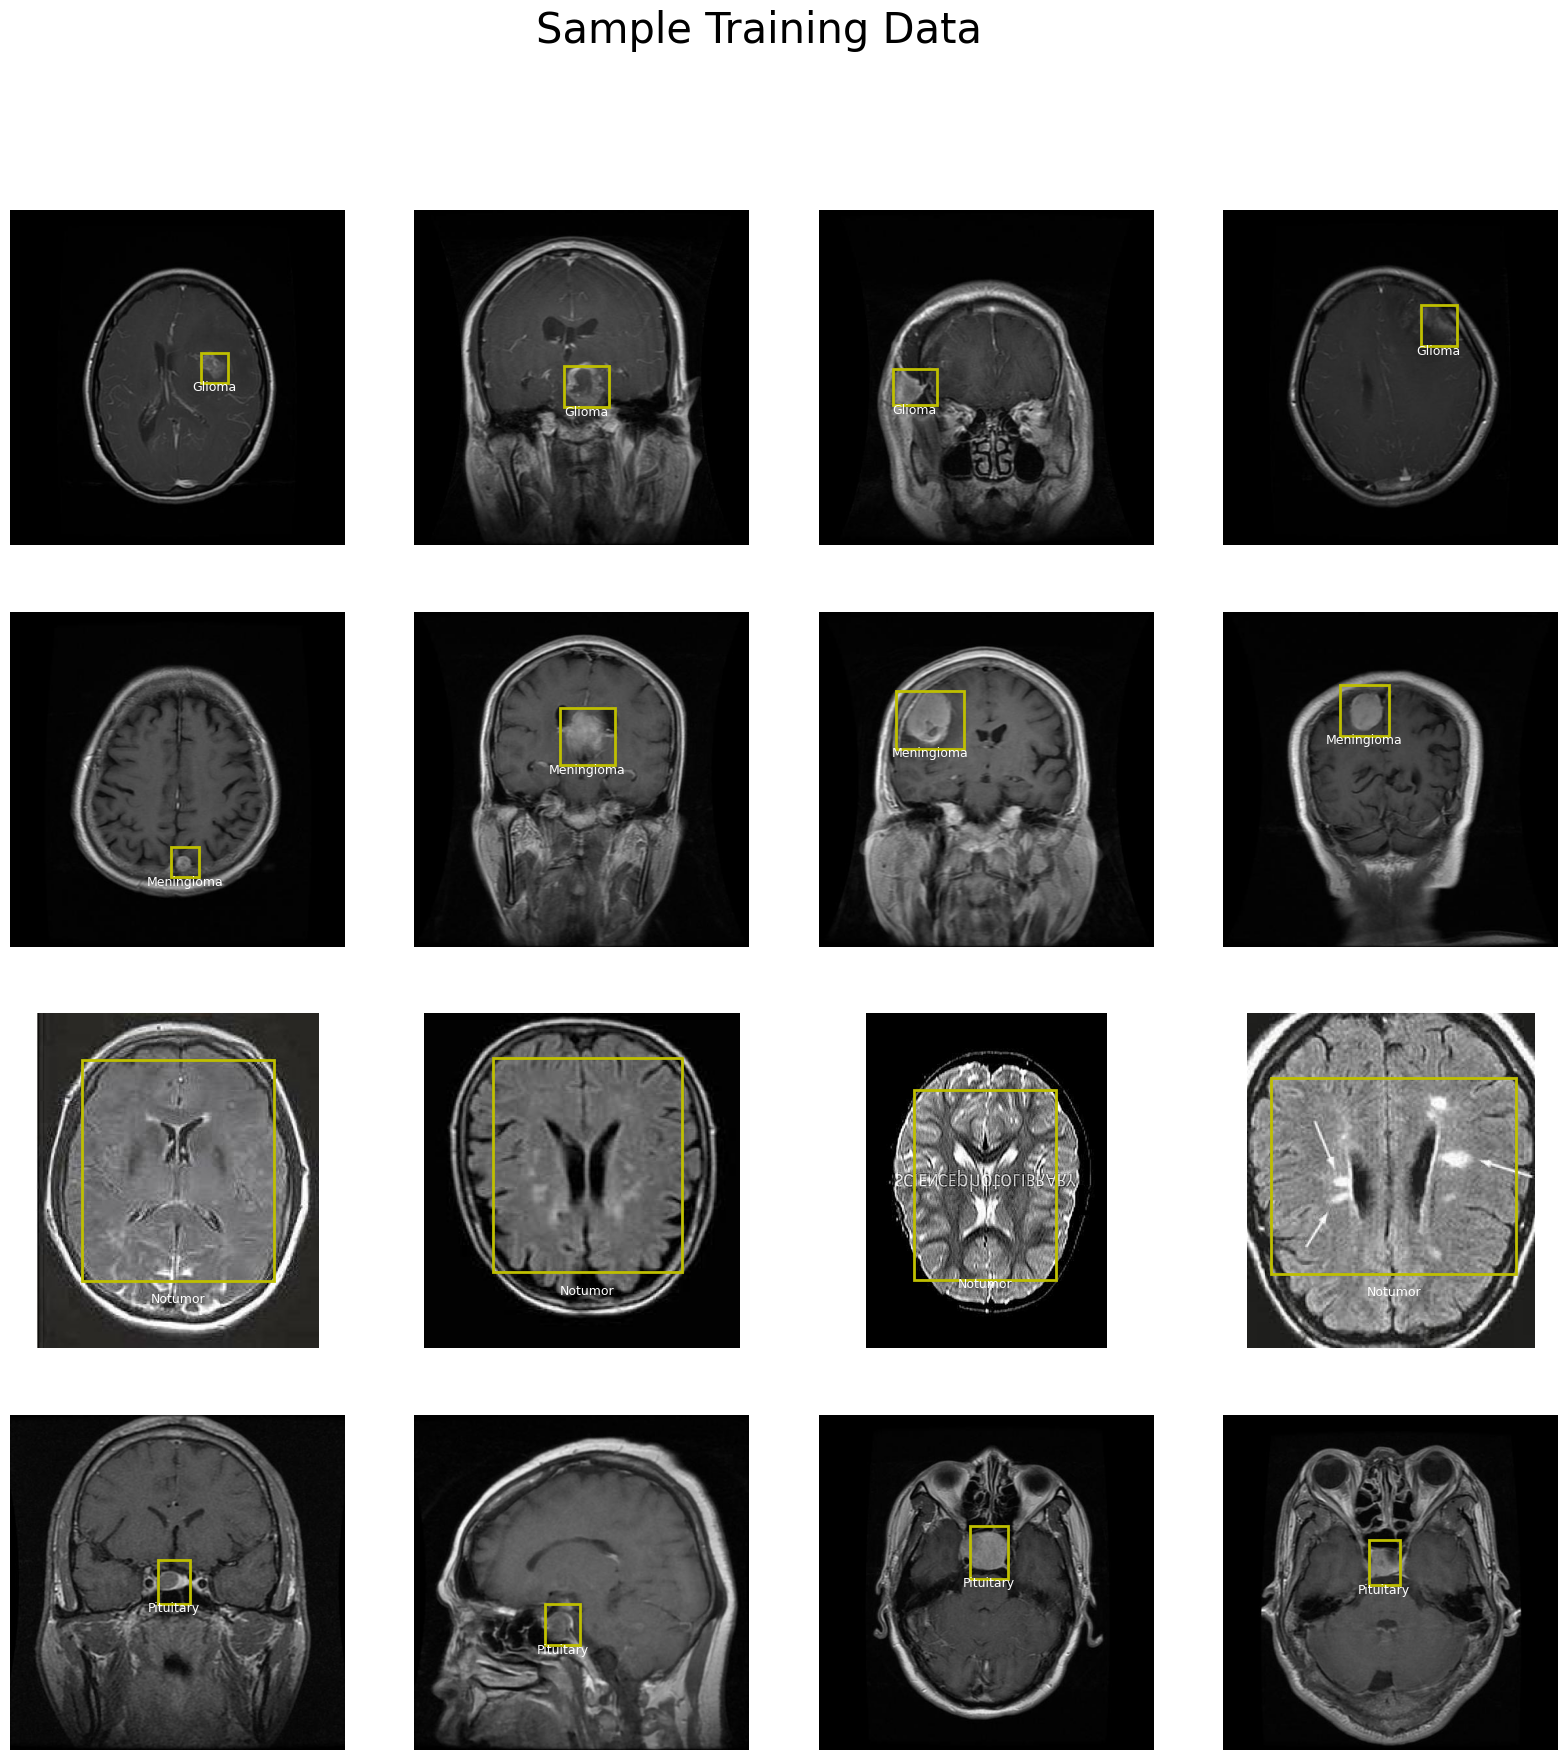

In [7]:

dataset_directory = '/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='y', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

In [8]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):

    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

In [9]:
dataset_directory = '/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [10]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [11]:
def plot_image_counts(train_directory, test_directory):

    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

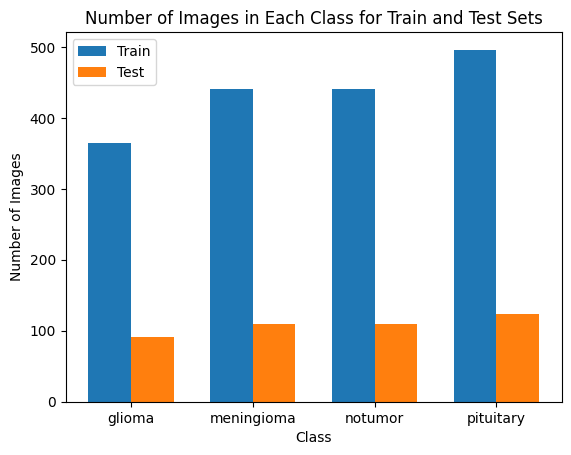

In [12]:
dataset_directory = '/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset'
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

In [13]:
yolo_btd_model = YOLO('yolov8n.yaml')

yolo_btd_model_results = yolo_btd_model.train(data='/content/drive/MyDrive/Braintumor classification/brain_tumor_dataset.yaml', epochs=25)

Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Braintumor classification/brain_tumor_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

In [15]:
from google.colab import files


best_model_path = "/content/runs/detect/train/weights/best.pt"


files.download(best_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

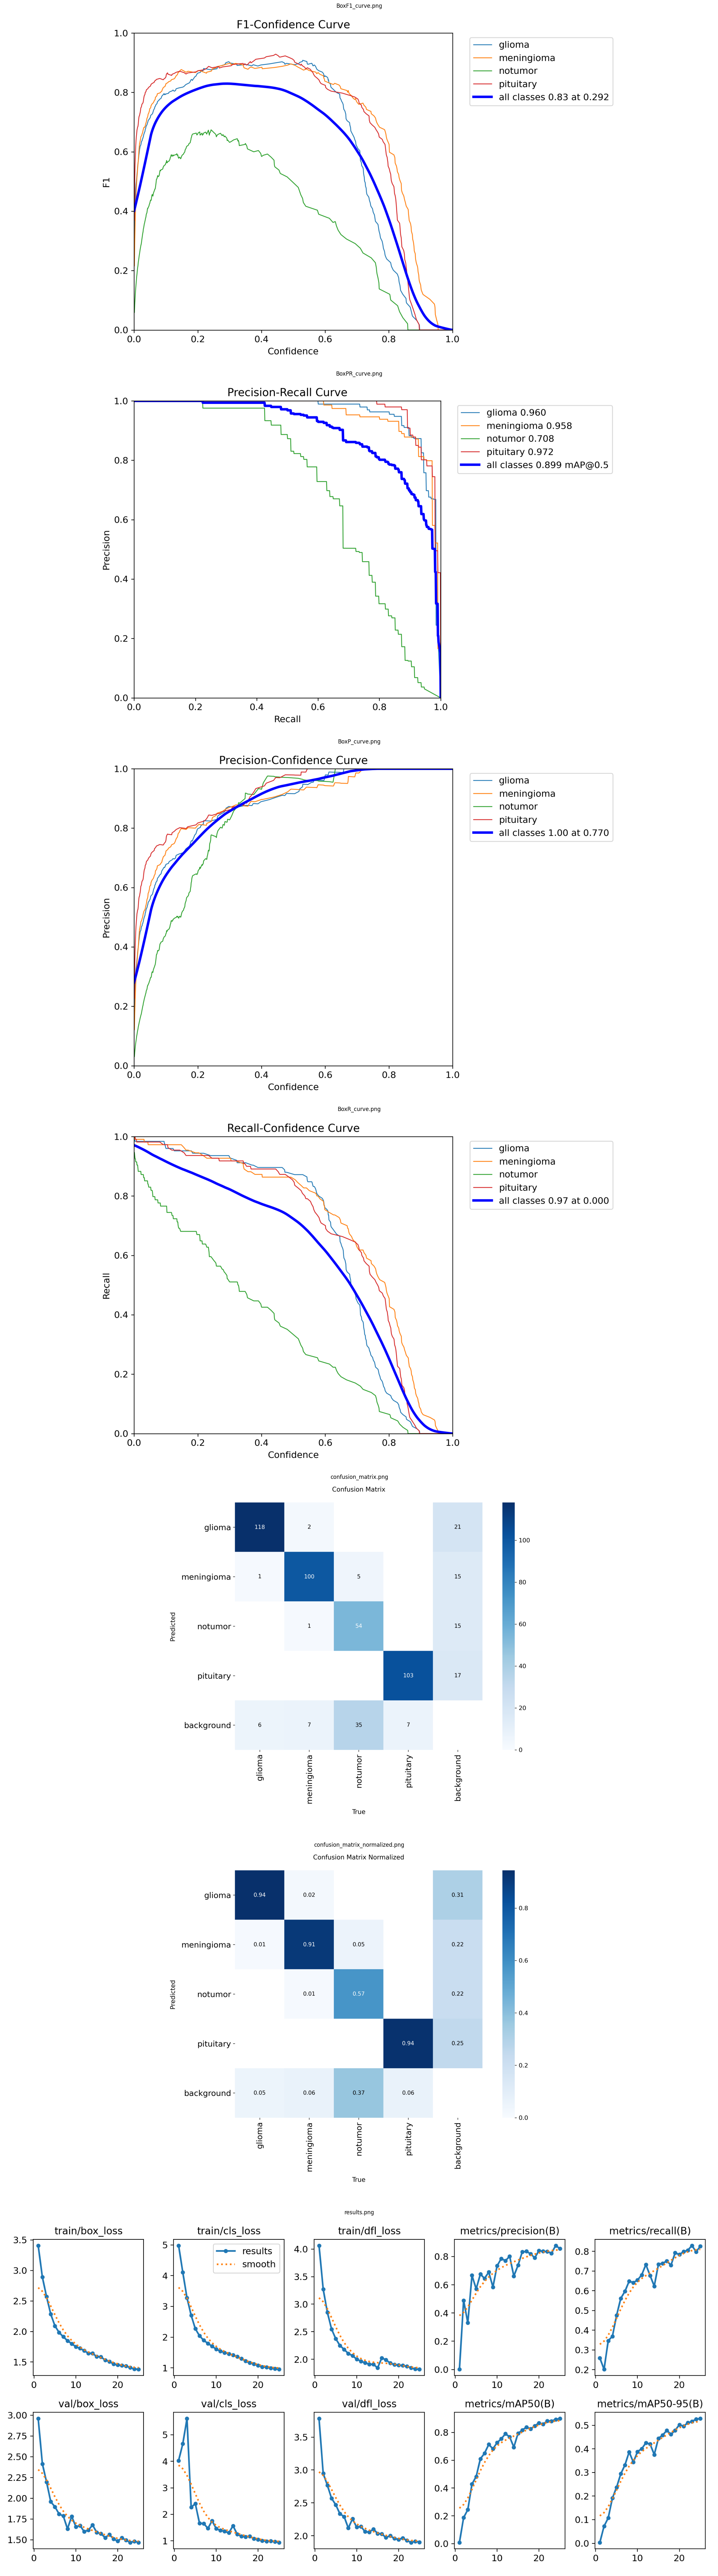

In [19]:
image_paths = [
    '/content/runs/detect/train3/BoxF1_curve.png',
    '/content/runs/detect/train3/BoxPR_curve.png',
    '/content/runs/detect/train3/BoxP_curve.png',
    '/content/runs/detect/train3/BoxR_curve.png',
    '/content/runs/detect/train3/confusion_matrix.png',
    '/content/runs/detect/train3/confusion_matrix_normalized.png',
    '/content/runs/detect/train3/results.png',

]
plot_images(image_paths)

In [20]:
def predict_results(test_images_dir):
    model = YOLO('/content/runs/detect/train3/weights/best.pt')
    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=320, conf=0.3)

In [25]:
glioma_test_dir = '/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/glioma'
predict_results(glioma_test_dir)


image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/glioma/Tr-gl_0011.jpg: 320x320 (no detections), 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/glioma/Tr-gl_0022.jpg: 320x320 1 notumor, 14.0ms
Speed: 1.5ms preprocess, 14.0ms inference, 2.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/glioma/Tr-gl_0025.jpg: 320x320 1 notumor, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/glioma/Tr-gl_0029.jpg: 320x320 2 notumors, 8.4ms
S

In [26]:
meningioma_test_dir = '/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/meningioma'
predict_results(meningioma_test_dir)


image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/meningioma/Tr-me_0010.jpg: 320x320 2 meningiomas, 9.7ms
Speed: 13.5ms preprocess, 9.7ms inference, 7.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict2

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/meningioma/Tr-me_0012.jpg: 320x320 (no detections), 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict2

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/meningioma/Tr-me_0016.jpg: 320x320 1 meningioma, 25.1ms
Speed: 5.6ms preprocess, 25.1ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict2

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/meningioma/Tr-me_0019.jpg

In [27]:
notumor_test_dir = '/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/notumor'
predict_results(notumor_test_dir)


image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/notumor/Tr-no_0010.jpg: 320x320 (no detections), 9.4ms
Speed: 1.0ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict3

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/notumor/Tr-no_0012.jpg: 320x320 1 pituitary, 5.3ms
Speed: 0.9ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict3

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/notumor/Tr-no_0016.jpg: 320x320 1 pituitary, 26.6ms
Speed: 7.3ms preprocess, 26.6ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict3

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/notumor/Tr-no_0019.jpg: 320x320 (no dete

In [28]:
pituitary_test_dir = '/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/pituitary'
predict_results(pituitary_test_dir)


image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0012.jpg: 320x320 1 glioma, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict4

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0016.jpg: 320x320 (no detections), 5.8ms
Speed: 0.8ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict4

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0020.jpg: 320x320 1 glioma, 41.1ms
Speed: 1.3ms preprocess, 41.1ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict4

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0037.jpg: 320x256 1 glio


image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/glioma/Tr-gl_0022.jpg: 640x640 1 notumor, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/meningioma/Tr-me_0010.jpg: 640x640 2 meningiomas, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/notumor/Tr-no_0010.jpg: 640x640 1 pituitary, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0012.jpg: 640x640 1 glioma, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


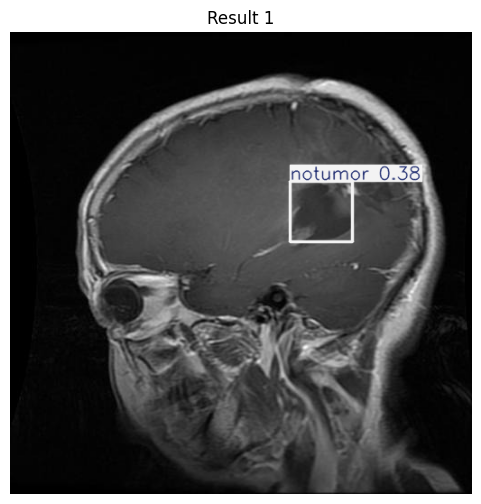

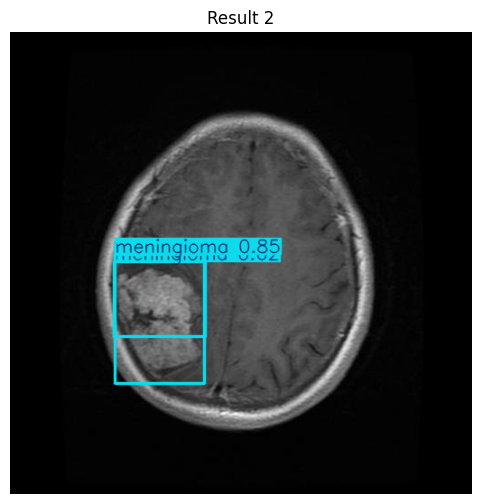

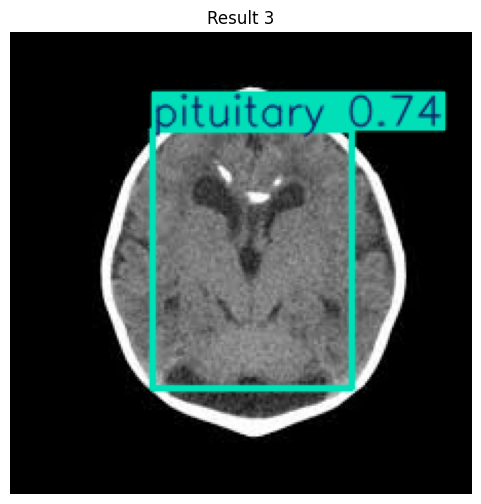

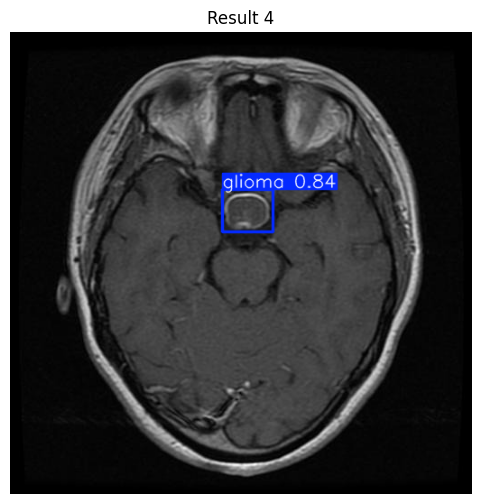

In [23]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

model = YOLO("/content/drive/MyDrive/Braintumor classification/best.pt")

image_paths = [
    "/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/glioma/Tr-gl_0022.jpg",
    "/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/meningioma/Tr-me_0010.jpg",
    "/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/notumor/Tr-no_0010.jpg",
    "/content/drive/MyDrive/Braintumor classification/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0012.jpg"
]


results_list = [model(path) for path in image_paths]


for i, results in enumerate(results_list):
    res_img = results[0].plot()
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Result {i+1}")
    plt.axis("off")
    plt.show()



